# Visualization and explore the Wildfire data with Matplotlib, Pandas and Seaborn

This notebook will connect to a MySQL DB in the cloud which houses a combined table for wild
fires in the US and weather conditions during each fire. Independent features will be evaluated 
for collerlation and usefulness in a model. The goal of the model is to predict the fire intensity based on the fire features and the weather.

### Getting Started:
#### Importing the libraries 

In [42]:
%matplotlib inline
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

from sqlalchemy import create_engine   #sql engine

import yellowbrick as yb

import pylab as pl
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


import config #database connection variables 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

### Connect to mySQL database in the cloud
Requires config files stored in the same directory as the notebook, contains the connection information 

Save the data to disk for faster access in the future


In [43]:
def read_from_db() : 
    
    # create sqlalchemy engine
    engine = create_engine("mysql+mysqlconnector://{user}:{password}@{host}/{dbname}"
                       .format(user=config.db_user,
                               password=config.db_pass,
                               dbname=config.db_main,
                               host=config.db_host))
    
    #Create Query Statments

    queryFire = """
    SELECT *
    FROM Fire_Intensity_Model_Clean
    LIMIT 20000;
    """

    
    #Execute Queries
    df_fires = pd.read_sql(queryFire, engine)

    #close the database connection
    engine.dispose()
    
    
    df_fires.to_csv('data/fires1.csv', index = False)
    
    

#### Read from to cloud db
Skip if reading from disk

In [ ]:
read_from_db()

### Read data from disk previously stored for faster access 

In [72]:
#Read the data from disk for faster access
df_fires = pd.read_csv('data/FireIntensity_Model_June7_Clean.csv').sample(250000)

df_fires.head()

,latitude,longitude,doy,month,year,cluster_reference,fire_region,season,covertype,fuelcode,...,temperature,humidity,precip_intensity,visibility,wind_speed,wind_gust,brightness,fire_intensity,bright_t31,frp
347910,45.5613,-109.8902,240,8,2006,2006_1069,1,1,3,1200,...,75.80,0.2500,0.0,9.216293,6.02,12.230000,336.0,Severe,302.8,38.3
369358,30.8068,-92.3020,278,10,2006,2006_2180,0,2,1,1,...,89.90,0.5000,0.0,8.207000,4.84,11.030000,320.2,High,296.5,44.7
187115,39.3263,-90.8617,76,3,2005,2005_2357,0,3,3,1800,...,57.53,0.2600,0.0,9.997000,14.96,21.860000,314.4,Medium,294.5,11.3
1151632,39.5296,-96.5002,88,3,2014,2014_1733,3,0,1,1,...,42.44,0.5700,0.0,9.216293,3.67,7.120000,343.9,Severe,293.6,141.7
1111388,31.4476,-87.7340,251,9,2013,2013_2481,0,1,3,1160,...,84.98,0.4111,0.0,9.216293,4.70,11.681998,316.7,Medium,301.7,9.7


### Display the head of data for check.

In [ ]:
print(df_fires.columns)

### Analyze the features in the machine learning table

<i> Goal is to predict the fire intensity</i>

In [73]:
#drop columns which are not relevant 

#remove index column if reading from cloud
df_fires = df_fires.drop(columns=['year', 'cluster_reference', 'latitude', 'longitude', 'month', 'covertype', 
                                  'brightness', 'bright_t31', 'frp'])


In [65]:
#show the shape of the data
print (df_fires.shape)

#show the data by fire_intensity 
print(df_fires.groupby('fire_intensity').count())



(20000, 13)
                 doy  fire_region  season  fuelcode  prefire_fuel  \
fire_intensity                                                      
High            5086         5086    5086      5086          5086   
Low             4996         4996    4996      4996          4996   
Medium          4967         4967    4967      4967          4967   
Severe          4951         4951    4951      4951          4951   

                fuel_moisture_class  temperature  humidity  precip_intensity  \
fire_intensity                                                                 
High                           5086         5086      5086              5086   
Low                            4996         4996      4996              4996   
Medium                         4967         4967      4967              4967   
Severe                         4951         4951      4951              4951   

                visibility  wind_speed  wind_gust  
fire_intensity                          

### Visualize home many of each type of dependent variables we have (1-4)

Use seaborn to plot a count histogram. We have 4 separate categories.
1 (not burned), 2 (light), 3(med), 4 (heavy burn)

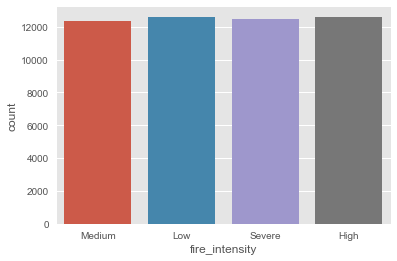

In [47]:
sns.countplot(df_fires['fire_intensity'],label="Count")
plt.show()

### Draw box diagram to see scale and quartiles of data
Data is on a very large scale with could affect some models scaling maybe needed.


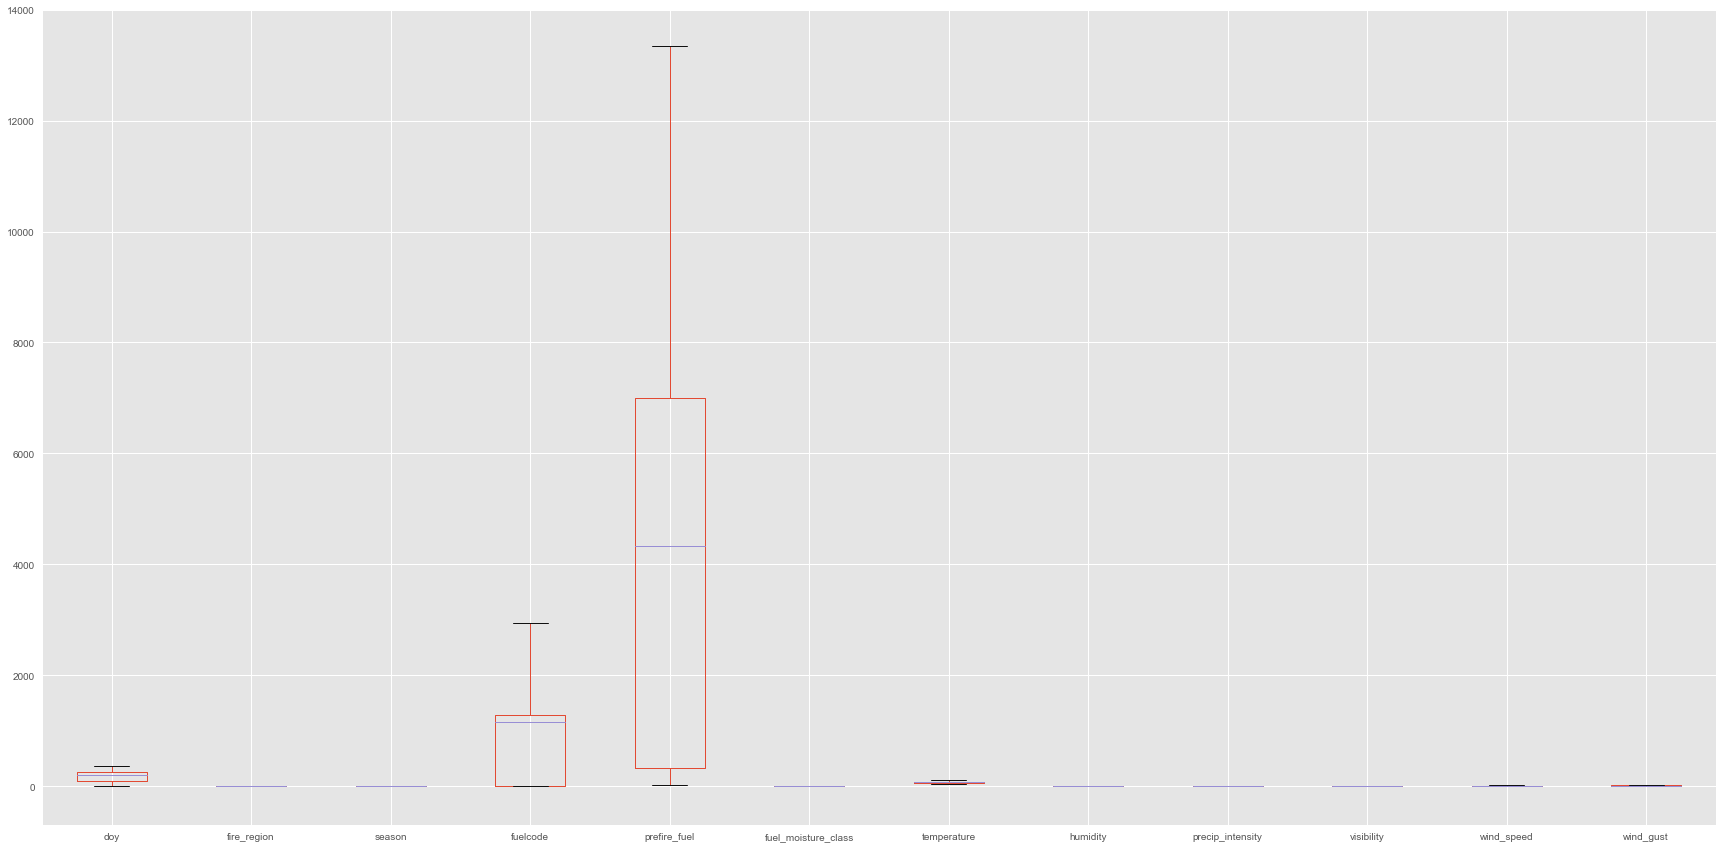

In [48]:
#draw box plot of see range of the data
import matplotlib
matplotlib.style.use('ggplot')
df_fires.plot(kind='box',figsize=(30,15))



### View histogram of all numerical data to better understand the distribution
Graphs show some data is continous while others are categorical. 
No normal distribution shown.Correlations can be seen between ECO/ECO2, EPM2.5/Consumed fuel

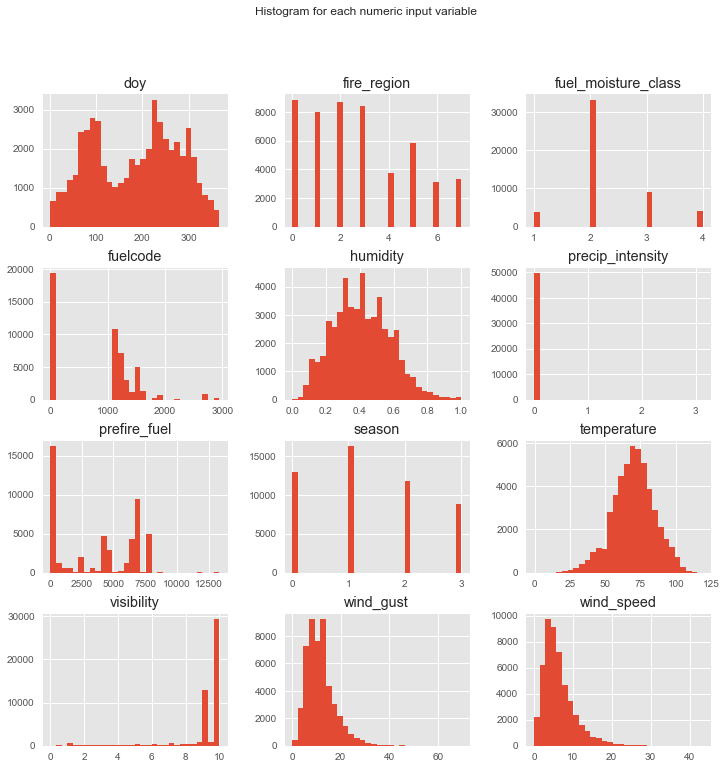

In [7]:
#historgram of all numerical data
df_fires.hist(bins=30, figsize=(12,12))
pl.suptitle("Histogram for each numeric input variable")
plt.show()

In [ ]:
print(df_fires.columns)


### Scatter matrix plot for the continous values - categorical does not present much value
<i> These features can likely be combined or dropped. Note this take a long time to run (minutes)</i> 

anlaysis says to take out years, month,frp, brightness

#warning takes a long time to run best to skip - not helpful for our data

In [ ]:

""" 
#draw scatter matrix 



#update the feature list if you removed features
feature_names = ['doy', 'fire_region', 'season',
                'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                'temperature', 'humidity', 'precip_intensity',
                'wind_speed', 'wind_gust']

X = df_fires[feature_names]
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':20}, figsize=(25,25), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
"""

### Show which features likely have the most impact 
<i> RadViz in unclear</i>

/Users/sandstone/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


         temperature     wind_speed       humidity    fire_region  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean       69.934560       6.369278       0.411720       2.740816   
std        15.013486       4.144228       0.168467       2.120283   
min         0.000000       0.000000       0.020000       0.000000   
25%        60.580000       3.550000       0.290000       1.000000   
50%        70.380000       5.430000       0.400000       2.000000   
75%        79.550000       8.100000       0.530000       4.000000   
max       139.550000      66.300000       1.000000       7.000000   

              season       fuelcode   prefire_fuel  fuel_moisture_class  \
count  250000.000000  250000.000000  250000.000000        250000.000000   
mean        1.335800     831.315912    3861.510776             2.260748   
std         1.046301     709.197788    3008.015012             0.707554   
min         0.000000       1.000000      19.615050             1.000000   
25%

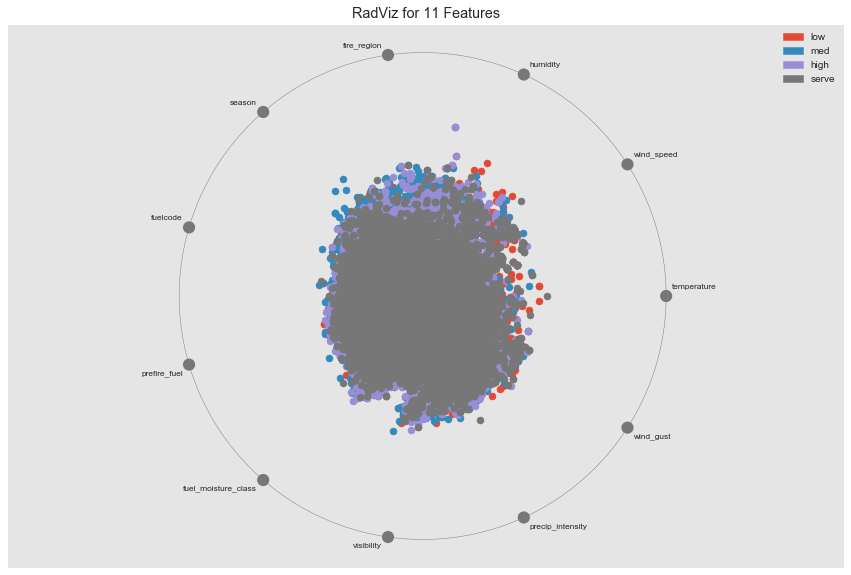

In [74]:
from yellowbrick.features import RadViz

#drop features for simplicity lat/lon/doy/visiblity 
feature_names = [ 'temperature', 'wind_speed','humidity', 'fire_region', 'season', 
                 'fuelcode', 'prefire_fuel', 'fuel_moisture_class',
                 'visibility', 'precip_intensity', 'wind_gust']


#remove negative values from fire
X = df_fires[feature_names]
ind = 0

for ind in df_fires['temperature'].index:      
        if df_fires['temperature'][ind] < 0:
            df_fires['temperature'][ind] = 0

"""        
print(df_fires['temperature'][ind])

for temp in df_fires['tempearture']:
    type (temp)
    #if temp[ind] > 0:
        #type(temp)
        #temp[ind] = -30
        #df_fires['temperature'].index(ind) = temp
    ind = ind + 1
"""
    
X = df_fires[feature_names]
print(X.describe())

#df_fires['tempearture'] = StandardScaler().fit_transform(df_fires['temperature'])

#X = StandardScaler().fit_transform(X)
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)

# Specify the target classes
classes = ["low", "med", "high", "serve"]

# Instantiate the visualizer
visualizer = RadViz(classes=classes, features=feature_names, size=(1080, 720))

visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show()              # Draw the data

### Show Random forest classier of the most important features to predict severity

<i>  I get different answers eveytime I run this but a random decision tree? Top and bottom half are consistent though. Run 3-4 times to get a feel </i>

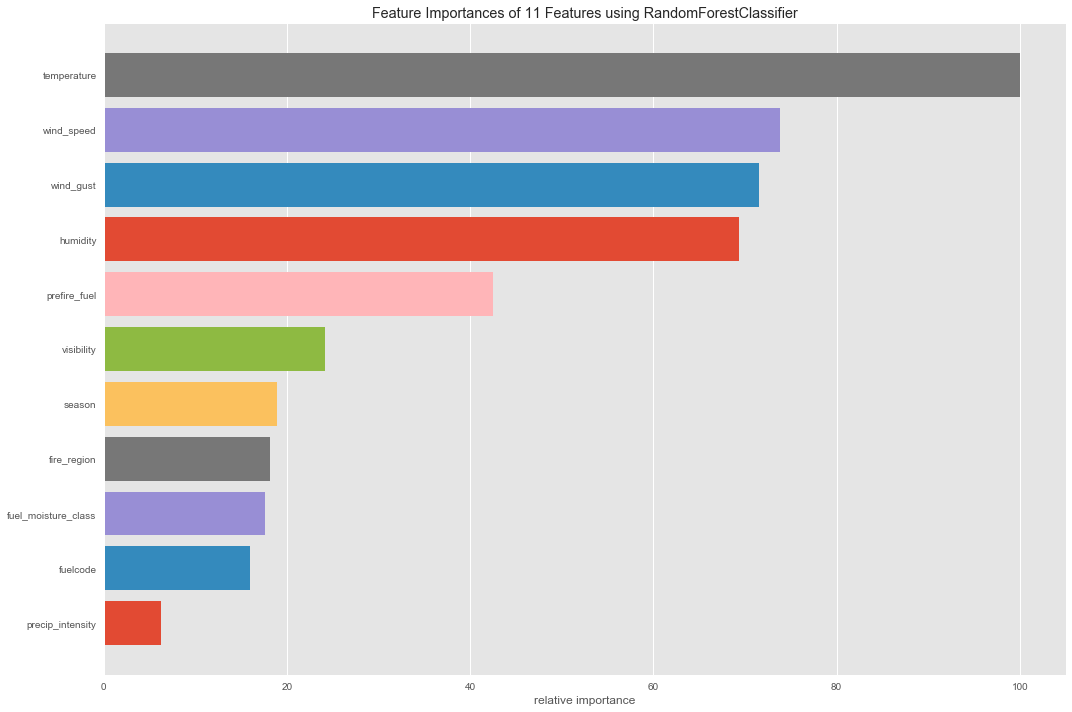

In [75]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=20)
viz = FeatureImportances(model, labels=feature_names, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.show()

### Visualize using rank 2D
<i> This shows a high digree of multicollinearity. Columsn can likely be combined or dropped </i>

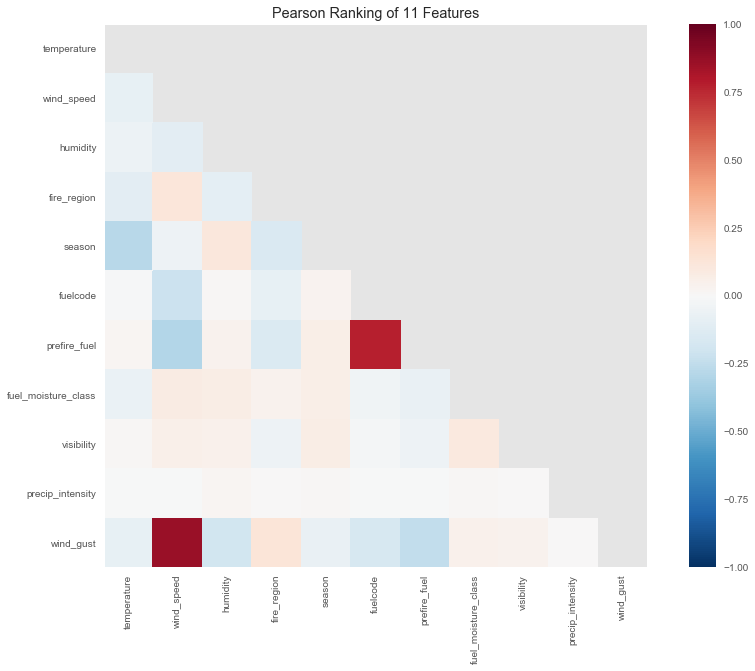

In [54]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', features=feature_names, size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

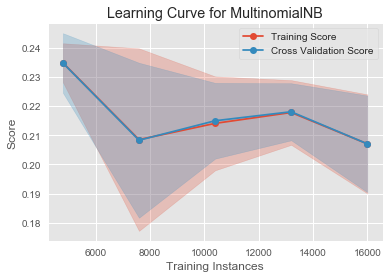

In [67]:
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB


from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve

# Load a classification dataset
#X, y = load_game()

# Encode the categorical data
X = df_fires[feature_names]
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)
#X = OneHotEncoder(categories="auto").fit_transform(X)
#X = StandardScaler().fit_transform(X) 

#X is throwing an error as negative  need to check

# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 5)

# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
# Instantiate the classification model and visualizer
#Only run if you have time

"""
model = LinearSVC()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

"""





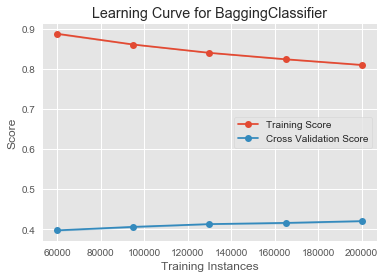

In [62]:
# Instantiate the classification model and visualizer

X = df_fires[feature_names]
y = df_fires['fire_intensity']
y = LabelEncoder().fit_transform(y)
#X = OneHotEncoder(categories="auto").fit_transform(X)
#X = StandardScaler().fit_transform(X) 

model = BaggingClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

     

In [ ]:
# Instantiate the classification model and visualizer
model = ExtraTreesClassifier(n_estimators=5)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

  

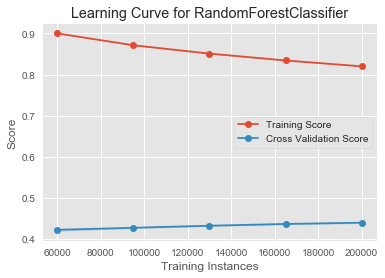

In [76]:
# Instantiate the classification model and visualizer
model = RandomForestClassifier(n_estimators=100)
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


In [ ]:
model = AdaBoostClassifier()
visualizer = LearningCurve(
    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
#save to ML CVS files
df_fires.to_csv('data/fires2.csv',index = False)